# 5001_individual_project start

In [0]:
# install necessary packages to access google drive.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate

··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import math
from os.path import join as pjoin

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

def train_and_cross_vali(model_name, model, X, y, verbose=1):
    scores = cross_val_score(model, 
                             X, 
                             y, 
                             cv=5, 
                             n_jobs=2, 
                             scoring=make_scorer(mean_squared_error))#mean_absolute_error))#
    score = scores.mean()
    if verbose > 0:
        print(f"{model_name} crossvali score: {score}")
    return score
    
def train_and_score(model_name, model, X_train, X_test, y_train, y_test, verbose=1):
    model = model.fit(X=X_train, y=y_train)
    score = 'NaN'
    if len(X_test) > 0:
        score = model.score(X_test, y_test)
    if verbose > 0:
        print(f"{model_name} fit score: {score}")
    return score


In [0]:
data_dir='drive/msbd5001_project/dataset'
data = pd.read_csv(pjoin(data_dir, 'train_all.csv'))

In [0]:
def eda(data):
   
    # onehot for penalty
    data = pd.get_dummies(data, columns=['penalty'])
    data.rename(index=str, inplace=True,
                columns={"penalty_elasticnet":"p1",
                    "penalty_l1":"p2",
                    "penalty_l2":"p3",
                    "penalty_none":"p4"})
    
    col_jobs = data['n_jobs']
    col_jobs[col_jobs==-1]=16
    
    # outliers
#     data = data[np.abs(data-data.mean()) <= (3*data.std())]
#     data.dropna(axis=0, inplace=True)
#     data = data.reset_index(drop=True)

    # new features
    data_amount = data['n_features']*data['n_samples']*data['max_iter']
    data_amount_perr_processor = data_amount / data['n_jobs']
    data_amount_perr_processor_extend = data_amount_perr_processor * data['flip_y']
    
    data_amount_perr_processor_extend_2 = data['n_features']*data['n_samples']*data['max_iter']*np.power(10,data['flip_y'])
    
    # add new feature
    data['new_fsi'] = data['n_features']*data['n_samples']*data['max_iter'] 
    data['fsi_j'] = data['new_fsi'] / data['n_jobs']
    data['p1_fsij'] = data['p1'] * data['fsi_j']
    data['p2_fsij'] = data['p2'] * data['fsi_j']
    data['p3_fsij'] = data['p3'] * data['fsi_j']
    data['p4_fsij'] = data['p4'] * data['fsi_j']
    
    data['p1_clz'] = data['p1'] * data['n_classes']
    data['p2_clz'] = data['p2'] * data['n_classes']
    
    data['p1_fy'] = data['p1'] * data['flip_y']
    data['p2_fy'] = data['p2'] * data['flip_y']
   

    return data

In [0]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Flatten, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize, scale, StandardScaler
import tensorflow as tf


data = pd.read_csv(pjoin(data_dir, 'train_all.csv'))
data = eda(data)
data_test = pd.read_csv(pjoin(data_dir, 'test.csv'))
data_test = eda(data_test)
data_all = data_test.append(data)
data_all.drop(columns='time', axis=1, inplace=True)

corr = data.corr()
keys = corr.query('abs(time) >= 0.1').index.tolist()
keys.remove('time')

# standardlize
data[keys] = (data[keys] - data_all[keys].mean()) / data_all[keys].std()

x_data = data[keys]
y_data = data['time']

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.23, random_state=5001)

dim = x_data.shape[1]


def build_model_2():
  model = Sequential()
  model.add(Dense(units=dim, activation='tanh', input_shape=(dim,)))
  model.add(Dense(units=1024, activation='tanh', input_shape=(dim,), kernel_initializer='normal'))
  model.add(Dense(units=512, activation='tanh', input_shape=(dim,), kernel_initializer='normal'))
  model.add(Dropout(0.5))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=64, activation='relu'))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dense(units=16, activation='relu'))
  model.add(Dense(units=8, activation='relu'))
  model.add(Dense(units=1, activation='relu'))

  # compile the model
  model.compile(optimizer='adam', loss='mse')
  # model.summary()
  return model


def train_nn(model, X_train=X_train, y_train=y_train, epochs=300, batch_size=500):
  early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=2)
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience=30,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
  # without data augmentation
  history = model.fit(X_train, y_train, batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_test, y_test), 
                      verbose=0, 
                      shuffle=False, callbacks=[learning_rate_reduction])#, early_stopping])
  err = model.evaluate(X_test, y_test, batch_size=1, verbose=1)

  print(f"ep@{epochs}, bs@{batch_size} get err: {err}")

  return history

['max_iter', 'n_jobs', 'n_samples', 'n_features', 'n_classes', 'n_informative', 'flip_y', 'p1', 'p2', 'p3', 'p4', 'new_fsi', 'fsi_j', 'p1_fsij', 'p2_fsij', 'p1_clz', 'p2_clz', 'p1_fy', 'p2_fy']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_441 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_442 (Dense)            (None, 1024)              20480     
_________________________________________________________________
dense_443 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_89 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_444 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_90 (Dr

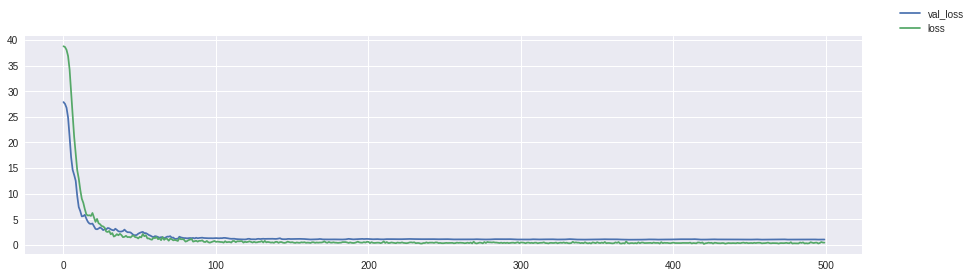

In [0]:
print(keys)
model = build_model_2()
model.summary()
history = train_nn(model, X_train, y_train, epochs=500, batch_size=200)

figsize=(15,4)
fig = plt.figure(figsize=figsize) 
plt.plot(history.history['val_loss'], label='val_loss') 
plt.plot(history.history['loss'], label='loss')
legend = fig.legend(loc='best', shadow=True)
fig.show()

In [0]:
# retain the model
model = build_model_2()
history = train_nn(model, x_data, y_data, epochs=500, batch_size=200)


Epoch 00184: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00278: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00348: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00378: ReduceLROnPlateau reducing learning rate to 0.0001.
102/102 [==============================] - 0s 4ms/step
ep@500, bs@200 get err: 0.05078895019710663


In [0]:
model.save('drive/ml_trained_models/5001_model_.h5')

In [0]:
data = pd.read_csv(pjoin(data_dir, 'train_all.csv'))
data = eda(data)
data_test = pd.read_csv(pjoin(data_dir, 'test.csv'))
data_test = eda(data_test)

data_all = data_test.append(data)
data_all.drop(columns='time', axis=1, inplace=True)

# standardlize
data_test[keys] = (data_test[keys] - data_all[keys].mean()) / data_all[keys].std()

x_data_test = data_test[keys]
# x_data_test = StandardScaler().fit_transform(x_data_test)

In [0]:
y_predicted = model.predict(x_data_test)

In [0]:
y_predicted = y_predicted.reshape(100)

In [0]:
f_name = pjoin(data_dir, 'submission_dnn.csv')
with open(f_name, 'w') as f:
    f.write("Id,time"+ '\n')
    for index, x in enumerate(y_predicted.tolist()):
        if x<0:
            x=0
        f.write(f"{index},{str(x)}" + '\n')

In [0]:

# def build_model_2_bak():
#   model = Sequential()
#   model.add(Dense(units=16, activation='tanh', input_shape=(dim,)))
#   model.add(Dense(units=1024, activation='tanh', input_shape=(dim,), kernel_initializer='normal'))
# #   model.add(Dropout(0.25))
#   model.add(Dense(units=512, activation='tanh', input_shape=(dim,), kernel_initializer='normal'))
#   model.add(Dropout(0.5))
#   model.add(Dense(units=256, activation='relu'))#, kernel_initializer='normal'))
#   model.add(Dropout(0.1))
#   model.add(Dense(units=128, activation='relu'))#, kernel_initializer='normal'))
#   model.add(Dense(units=64, activation='relu'))#, kernel_initializer='normal'))
#   model.add(Dense(units=32, activation='relu'))#, kernel_initializer='normal'))
#   model.add(Dense(units=16, activation='relu'))#, kernel_initializer='normal'))
#   model.add(Dense(units=1, activation='relu'))#, kernel_initializer='normal'))#, activation='softmax'))

#   # define the optimizer
#   # compile the model
#   model.compile(optimizer='adam', loss='mse')#), metrics=['mae', 'acc'])
#   # model.summary()
#   return model
